In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.datasets import MNIST
import pickle
import networkx as nx
from model import LitMNIST

<AxesSubplot: >

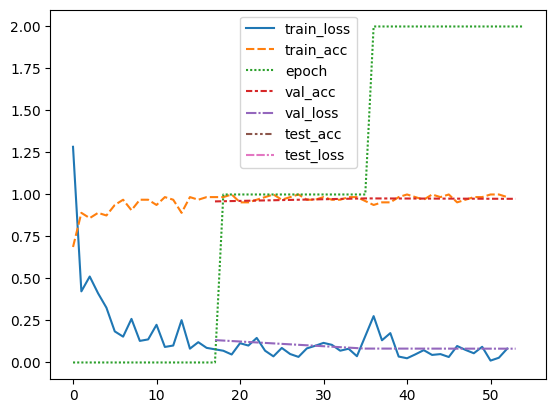

In [97]:
metrics = pd.read_csv("logs/lightning_logs/version_8/metrics.csv")
del metrics["step"]
sns.lineplot(data=metrics)

In [98]:
def plot_graph(G, title, coords=True):
    '''Plot the graph'''
    plt.figure(figsize=(5,5))
    pos = dict((n, n) for n in G.nodes())
    nx.draw_networkx(G, pos=pos, with_labels=coords, node_size=30)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [99]:
def plot_path(G, agent, title, coords=True):
    '''Plot the graph with path'''
    plt.figure(figsize=(5,5))
    pos = dict((n, n) for n in G.nodes())
    nx.draw_networkx(G, pos=pos, with_labels=coords, node_size=30)
    nx.draw_networkx_nodes(G, pos=pos, 
                           nodelist=agent.visited, 
                           node_color='r', 
                           node_size=30)
    
    nx.draw_networkx_nodes(G, pos=pos, 
                           nodelist=agent.path, 
                           node_color='g', 
                           node_size=30)
    
    nx.draw_networkx_edges(G, pos=pos, 
                           edgelist=[(agent.path[i], agent.path[i+1]) for i in range(len(agent.path)-1)], 
                           edge_color='g', width=2)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [100]:
class Road():
    def __init__(self):
        self.graph = pickle.load(open('data/road.pickle', 'rb'))
        self.mnist = MNIST(root="./datasets", train=False, download=True) 
        self.speed_signs = {}
        for node in self.graph.nodes():
            while True:
                n = np.random.randint(0, self.mnist.targets.shape[0])
                self.speed_signs[node] = {'speed': int(self.mnist.targets[n]), 'image': self.mnist.data[n]}
                if self.speed_signs[node]['speed'] != 0:
                    break

In [101]:
from typing import Tuple, List

class Agent:
    def __init__(self, road, start: Tuple[int, int], end: Tuple[int, int]):
        self.road = road
        self.start = start
        self.end = end
        self.current = start
        self.visited = (start,)
        self.path = [start]
        self.knowledge = {}
        self.network = LitMNIST()
        self.network.load_state_dict(torch.load('data/model.pt'))
        self.network.eval()
        self.speed = [int(self.network(self.road.speed_signs[start]['image'].unsqueeze(0).unsqueeze(0).type(torch.float32)).argmax())]
        
        
    def get_next(self, node: Tuple[int, int]) -> List[Tuple[int, int]]:
        return tuple(self.road.graph[node])
    
    
    def heuristic(self, node1: Tuple[int, int], node2: Tuple[int, int]) -> int:
        return abs(node1[0] - node2[0]) + abs(node1[1] - node2[1])
    
    
    def is_locked(self, node: Tuple[int, int]) -> bool:
        return len(self.get_next(node)) == 1 and node != self.end
    
    
    def move(self, new: Tuple[int, int]):
        self.current = new
        self.path.append(new)
        self.visited += (new,)
        self.speed.append(int(self.network(self.road.speed_signs[new]['image'].unsqueeze(0).unsqueeze(0).type(torch.float32)).argmax()))


    def search(self):
        while self.current != self.end:
            self.tell()
            best = self.ask() 
            
            if best not in self.get_next(self.current):
                best = self.get_best_near(best)

            self.move(best)
            
                    
    def tell(self) -> None:
        for near_node in self.get_next(self.current):
            if self.is_locked(near_node):
                continue
            
            if near_node not in self.knowledge:
                self.knowledge[near_node] = self.heuristic(near_node, self.end)
                
            for far_node in self.get_next(near_node):        
                if far_node not in self.knowledge:
                    self.knowledge[far_node] = self.heuristic(far_node, self.end)
              
                 
    def ask(self) -> Tuple[int, int]:
        possible_moves = self.get_possible_moves(self.knowledge)
        return min(possible_moves, key=lambda node: self.knowledge[node])
    
    
    def get_possible_moves(self, node_list: List[Tuple[int, int]]):
        possible_moves = filter(lambda node: node not in self.visited, node_list)
        possible_moves = filter(lambda node: not self.is_locked(node), possible_moves)
        return list(possible_moves)
    
    
    def get_best_near(self, best: Tuple[int, int]) -> Tuple[int, int]:
        possible_moves = self.get_possible_moves(self.get_next(self.current))
        
        while len(possible_moves) == 0:
            self.path.pop()
            self.speed.pop()
            self.current = self.path[-1]
            possible_moves = self.get_possible_moves(self.get_next(self.current))         
        
        return min(possible_moves, key=lambda node: self.heuristic(node, best))

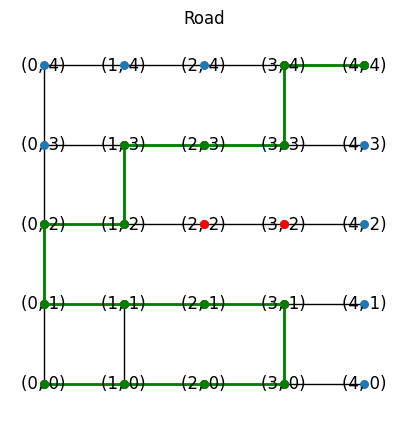

In [102]:
road = Road()
car = Agent(road, (0, 0), (4, 4))
car.search()

plot_path(road.graph, car, 'Road')

In [103]:
print('Path: ')
print(*car.path, sep=' -> ')

Path
(0, 0) -> (1, 0) -> (2, 0) -> (3, 0) -> (3, 1) -> (2, 1) -> (1, 1) -> (0, 1) -> (0, 2) -> (1, 2) -> (1, 3) -> (2, 3) -> (3, 3) -> (3, 4) -> (4, 4)


In [104]:
print('Predicted speed: ')
print(*car.speed, sep=' -> ')

Predicted speed: 
4 -> 3 -> 9 -> 7 -> 3 -> 6 -> 9 -> 3 -> 3 -> 7 -> 8 -> 4 -> 7 -> 9 -> 9


In [105]:
print('Real speed: ')
print(*[road.speed_signs[node]['speed'] for node in car.path], sep=' -> ')

Real speed: 
4 -> 3 -> 9 -> 7 -> 3 -> 6 -> 9 -> 3 -> 3 -> 7 -> 8 -> 4 -> 7 -> 9 -> 9
